# Pix2Pix 

Basado en ejemplo de tensorflow 


<td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
</td>


MR 

Febrero 2022

version 0.1


*Pix2pix*, propuesto por Isola et al.(2017), es red neuronal profunda que se basa en el entrenamiento tipo [GAN](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/dcgan/dcgan.html) de una red tipo [UNet](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/unet/unet_segmentacion.html). El modelo pix2pix calcula la transformación de una imagen $x$ en una imagen $y$ las cuales difieren, generalmente, en estilo. 

Para saber mas sobre la implementación deeste modelo pueded consultar las revisión de [Pix2Pix](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/pix2pix/pix2pix.html) donde se ven los detalles el tutorial de *Tensorflow*.

**Referencias**
(Isola, 2017) Phillip Isola et al. “Image-to-image translation with conditional adversarial networks”. In: Proceedings of the IEEE conference on computer vision and pattern recognition. 2017, pp. 1125–1134


## Problema a resolver

El propósito es segmentar las imágenes de rostros de CelebA HQ de acuerdo a los mapas de anotaciones. Los datos que usaremos seŕan las rostros de CelebA HQ ($x$) con sus respectivos mapas de etiquetas ($y$), ver la siguiente figura.


![images](segmap.png)


Diagrama de entrenamiento del modelo pix2pix.

![Generator Update Image](pix2pix_unet_gan.jpeg)

De acuerdo al diagrama de arriba, para entrenar el modelo pix2pix, es necesario dar como entradas tanto la imágen en el dominio de entrada $x$ como la del dominio de salida $y$. Luego cada vez que se realiza una predicción (de transformación) $x'$, se generan dos pares de imágenes, uno que contienen las imágenes reales ($x,y$) y otro conformado por la entradad y la predicción ($x,x'$). Ambas imágenes son evaluadas por la red totalmente convolucional Discriminadora para producir un tensor 3d de dimensiones ($h \times w \times c$). Cada elemento del tensor salida del Discriminador toma valores en el intervalo $[0,1]$, por lo que puede interpretarse como la probabilidad de que la región de soporte tiene las características (que dicha respuesta evalúa) de un par real. No podemos saber con de antemano que características evalúa cada elemento de la respuesta del discriminador: estos extractores de carácterísticas se entrenan dependiendo de la tarea.   

Lo interesante es que se analiza región (de soporte) por región (de soporte) los pares de imágenes, cada región pueded tener una calificación diferente de su "verasidad". 

La tarea del Disciminador es distinguir entre regiones que pertenecen al par real y al sintético. Mientras que la tarea del Generador es producir imágenes que confundan al Discriminador, tan realista como sea posible. 

Dado que idealmente el Discriminador produce una tensor de puros cerso si el par evaluado es sintético y de puros unos si es real, el función de costo implica calular la entropia cruzada (*cross-entropy*).

## Implementacion de pix2pix (ejemplo de tf)

A continuación presentamos nuestra versión comentadad del código ejemplo de tensorflow para pix2pix.

Iniciamos cargando librerias que usaremos.

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import time
import datetime
from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Definimos variables globales de nuestra implementación:

* Tamaño de las imágenes a procesar ($x,y,x'$).

* Número de canales de la imagen de salida, por si acaso de que fuera distinto al de la imagen de entrada.

* Tamaño del lote, se ha visto que el modelo pix2pix funciona adecuadamente con tamaños de lote pequeños, inclusive de tamaño 1.

* Número de épocas.

* Epoca de inicio (por si acaso retomamos el entrenamistos y desamos continuar con la numeración). 

In [2]:
INPUT_DIMS    = (256,256,3)
MASK_DIMS     = (512,512,1) 
OUTPUT_DIMS   = (256,256,1)

NUM_CLASSES   = 19
BATCH_SIZE    = 1
R_LOSS_FACTOR = 10000
EPOCHS        = 100
INITIAL_EPOCH = 0

Ubicamos los datos:

* El directorio X_FOLDER contiene los datos de las imágenes de entrada.

* El directorio Y_FOLDER contiene los datos de las imágenes de objetivo.

Asumimos que ambis directorios contienen el mísmo número de imágenes y que una vez ordenados el listado de archivos en cada directorio, los archivos se corresponden 1 a 1.

* El directorio DIR_MODELS_P2P será donde almacenaremos el modelo que durenate el entrenamiento tenga el mejor resultado parcial


In [3]:
# run params
X_FOLDER      = "/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256"
Y_FOLDER      = "/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512"
DIR_MODELS_P2P    = "./../results_vae_unet_hq_256_z128/models"

Creamos las listas de archivos en los directorios con la imágenes con que trabajaremos.

In [4]:
xfiles  = glob(os.path.join(X_FOLDER, '*.jpg'))
yfiles  = glob(os.path.join(Y_FOLDER, '*.png'))

In [5]:
xfiles.sort()
yfiles.sort()
xfiles=np.array(xfiles)
yfiles=np.array(yfiles)

A modo de validación, imprimimos los primeros 5 nombres en cada lista. Los directorios serán distintos, pero los nomnres de los archivos son iguales.

In [6]:
[print(x, y) for x,y in zip(xfiles[:5],yfiles[:5])];

/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256/0.jpg /home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512/0.png
/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256/1.jpg /home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512/1.png
/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256/10.jpg /home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512/10.png
/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256/100.jpg /home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512/100.png
/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img-256/1000.jpg /home/mariano/Data/CelebAMask-HQ/CelebA-HQ-maps-512/1000.png


Por propósitos de eficiencia, usaremos la librerá tensorflow.datasets para administrar la lectura de archivos. Para ello definimos 


* BUFFER_SIZE con el número total de (pares de) imágenes a procesar. Esto permitira que *datasets* pueda administrar adecuadamente la memoria de la CPU para cargar anticipadamente los datos.

* Dado que se sobrecarga el método *fit*, la variable *step_per_epoch* nos indicará cuando se habra concluido una época. ues los datos serán cargados por *dataset* asumiendo una *stream* infinita.

In [7]:
BUFFER_SIZE      = len(xfiles)
steps_per_epoch  = BUFFER_SIZE //BATCH_SIZE
print('num image files : ', BUFFER_SIZE)
print('steps per epoch : ', steps_per_epoch )

num image files :  30000
steps per epoch :  30000


# pix2pix: Traducción de Imagen-a-Imagen con una GAN condicional

Como dijimos, usaremos librerías de *Tensorflow* para cargar la imágenes y preprocesarlas. Ello nos permite usar estos procedimientos eficientemente con la librería `datasets`. 

Las imágenes estan en formato `jpg` por lo que leeremos el archivo con `tf.io.read_file` y posteriormente decodificamos es `stream` de bytes con ` tf.image.decode_jpeg`.

Se transforman a `float32`, en dimensión ($256 \times 256$) y con valores en el intervalo $[-1,1]$.

En  [pix2pix paper](https://arxiv.org/abs/1611.07004) realizan como aumentación de datos un flip horizontal aleatorio (izq. $\leftrightarrow$ der.).

A continuación definimos dos funciones auxilares para cargar los datos y guardar reusltados parciales en forma de mosaico.

In [8]:
def read_images(xfile, yfile, flip=True):
    '''
    lee par de imagenes jpeg y las reescala la tamaño deseado 
    
    flip horizontal aleatorio, sincronizado
    '''
    
    xim = tf.io.read_file(xfile)
    xim = tf.image.decode_jpeg(xim)
    xim = tf.cast(xim, tf.float32)
    xim = xim/127.5-1 
    # en caso de ser necesario cambiar las dimensiones de la imagen x al leerla
    xim = tf.image.resize(xim, INPUT_DIMS[:2],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                            
        
    yim = tf.io.read_file(yfile)
    yim = tf.image.decode_jpeg(yim)
    yim = tf.cast(yim, tf.float32)/(10)  # Etiquetas de clase de [0,10,20,30,...,(NUM_CLS-1)*10] -> [0,1, 3, ..., NUM_CLS-1]
    # en caso de ser necesario cambiar las dimensiones de la imagen y al leerla
    yim = tf.image.resize(yim, INPUT_DIMS[:2],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Aumentación sincronizada de dada imágen del par $(x,y)$, en este caso solo un flip der-izq
    if flip and tf.random.uniform(()) > 0.5:
        xim = tf.image.flip_left_right(xim)
        yim = tf.image.flip_left_right(yim)

    return xim, yim

def load_images(xfile, yfile, flip=True):
    '''
    lee par de imagenes jpeg y las reescala la tamaño deseado 
    flip horizontal aleatorio, sincronizado
    '''    
    return read_images(xfile, yfile, flip=True)

def load_test_images(xfile, yfile, flip=False):
    '''
    lee par de imagenes jpeg y las reescala la tamaño deseado 
    '''        
    return read_images(xfile, yfile, flip=False)

In [9]:
def display_images(x_imgs=None, y_imgs=None, rows=4, cols=3, offset=0):
    '''
    Despliega en forma de retícula pares de imágenes tomando cada una de una lista 
    '''

    plt.figure(figsize=(cols*5,rows*2.5))
    for i in range(rows*cols):
        plt.subplot(rows, cols*2, 2*i+1)
        plt.imshow((x_imgs[i+offset]+1)/2)
        plt.axis('off')
    
        plt.subplot(rows, cols*2,2*i+2)
        plt.imshow(y_imgs[i+offset])
        plt.axis('off')
                      
    plt.tight_layout()
    plt.show()

## Imágenes de ejemplo

Pares de imágenes ($x,y$), imagen entrada y su imagen destino.

In [10]:
rows=2
cols=2

x_imgs=[]
y_imgs=[]

for i in range(rows*cols):
    xim, yim = load_images(xfiles[i], yfiles[i])
    x_imgs.append(xim)
    y_imgs.append(yim)
    
print(x_imgs[0].shape, y_imgs[0].shape) # a modo de comprobacion

(256, 256, 3) (256, 256, 1)


2022-03-02 22:22:50.390959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 22:22:50.396015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 22:22:50.396716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 22:22:50.398031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Deplegamos pares de imagenes $(x,y)$ y comentamos abajo algunos detalles. 

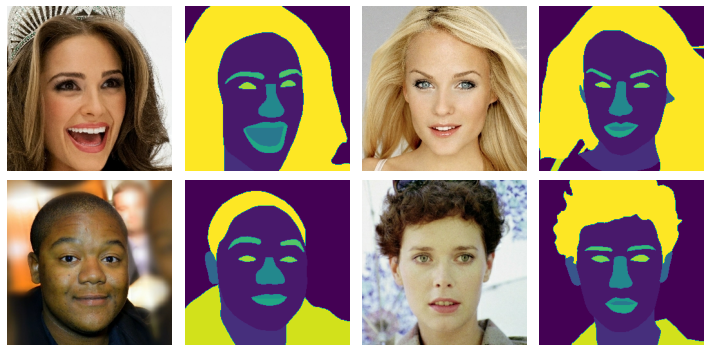

In [11]:
display_images(x_imgs, y_imgs, rows=rows, cols=cols)

Como podemos observar, la imagen de entrada parecec ser una versión "suavizada" de la imagen destino. Pero no es simplemente un suavizado el que las distingue. Podemos notar que la expresión de los rostros puede cambiar (por ejemplo la sonrisa de la rubia de arriba a derecha no esta presente en el rostro suavizado, ni el color de los ojos corresponde. Notamos que no existe una correpondencia pixel-a-Pixel entre las imágenes ($x,y$).  Lo mismo podemos decir para los demas róstros.

En resumen, de tarea que nos hemos impuesto, la de incluir textura en las imágenes "suaves" llevará al límite al modelo pix2pix. Veamos que pueded hacer el modelo.

In [12]:
xim, yim = load_images(xfiles[i], yfiles[i])
np.unique(yim)

array([-1.        , -0.8888889 , -0.7777778 , -0.5555556 , -0.44444442,
       -0.3333333 , -0.22222221, -0.1111111 ,  0.        ,  0.11111116,
        0.22222221,  0.33333337,  0.44444442,  0.5555556 ,  0.6666666 ],
      dtype=float32)

## Datasets

Con el 80% de la lista creamos primero un `tf.Dataset` de entrenamiento/validacion para los archivos de entrada (codificados) y otro para los objetivo (reales). Estos *datasets* estan ordenados tal que los archivos corresponden 1 a 1.

In [13]:
idx = int(BUFFER_SIZE*.8)

train_x = tf.data.Dataset.list_files(xfiles[:idx],shuffle=False)
train_y = tf.data.Dataset.list_files(yfiles[:idx],shuffle=False)

Luego, creamos un tercer dataset que que empareja los elementos de los anteriores datasets. Este dataset es creado con un `zip` de los dos primeros. 

Ahora si podemos permitir que sean remezclados en cada época (`shuffle`).

El dataset se conforma con pares de nombres de archivos, con idéntico nombre (en este caso) pero almacenados en distintos directorios. Leemos cada elemento del dataset al hacer `map` de la lectura cada elemento del nuevo data set (pareja de nombres de archivos). 

In [14]:
train_xy = tf.data.Dataset.zip((train_x, train_y))
train_xy = train_xy.shuffle(buffer_size=idx, reshuffle_each_iteration=True)
train_xy = train_xy.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
train_xy = train_xy.batch(BATCH_SIZE)

Igual procedemos para el restante 20% de archivos que conforman el dataset de prueba (`test`).

In [15]:
test_x = tf.data.Dataset.list_files(xfiles[idx:],shuffle=False)
test_y = tf.data.Dataset.list_files(yfiles[idx:],shuffle=False)

test_xy = tf.data.Dataset.zip((test_x, test_y))
test_xy = test_xy.map(load_test_images, num_parallel_calls=tf.data.AUTOTUNE)
test_xy = test_xy.batch(BATCH_SIZE)

Comprobamos que el objeto datset que lee pares de imágenes de directorios distintos esta sincronizado.

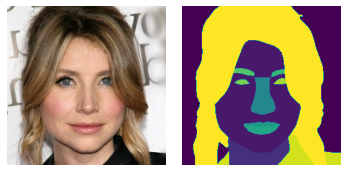

In [16]:
rows=1
cols=1
for x,y in train_xy.take(1):
    display_images(x, y, rows=rows, cols=cols)
    break

## Generator

El generador pix2pix cGAN es una modificación de la [U-Net](https://arxiv.org/abs/1505.04597).

Bloque de codificación (down-sampling)

In [17]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                      strides=2, 
                                      padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

Validamos el bloque de codificación

In [18]:
down_model  = downsample(3, 4)
down_result = down_model(tf.expand_dims(xim, 0))
print(down_result.shape)

2022-03-02 22:22:58.691065: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


(1, 128, 128, 3)


Bloque de decodicación (up-sampling)

In [19]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, 
                                               size, 
                                               strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [21]:
np_colormap = ((np.array(range(NUM_CLASSES))/(NUM_CLASSES-1))-0.5)*2
tf_colormap = tf.constant(np_colormap,  dtype=tf.float32)
tf_colormap = tf.reshape(tf_colormap, [1,1,1,NUM_CLASSES])
print(tf_colormap)

tf.Tensor(
[[[[-1.         -0.8888889  -0.7777778  -0.6666667  -0.5555556
    -0.44444445 -0.33333334 -0.22222222 -0.11111111  0.
     0.11111111  0.22222222  0.33333334  0.44444445  0.5555556
     0.6666667   0.7777778   0.8888889   1.        ]]]], shape=(1, 1, 1, 19), dtype=float32)


In [22]:
def decode_onehot (beta=10):
    weights = [i for i in range(numclasses)]
    weights = np.reshape(weights, (1,1,1,numclasses))
    initializer = tf.constant_initializer(weights)
    result  = tf.keras.Sequential()
    decoder1x1 = tf.keras.layers.Conv2D(filters=1, 
                                        kernel_size=1,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        trainable=False,
                                        activation=None)  
    result.add(decoder1x1)
    return result

def softargmax(x, beta = 10.0):
    alpha   = beta*x
    alpha   = tf.nn.softmax(alpha, axis =-1)
    output  = tf.math.multiply(alpha , tf_colormap)
    output  = tf.math.reduce_sum(output, axis=-1, keepdims=True)
    return output

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ScaleLayer, self).__init__()
        self.scale = tf.Variable(19.)

    def call(self, inputs):
        return inputs * self.scale

Las dimensiones son correctas, se `downsample` reduce el alto y ancho de los tensores en la mitad y `upsample` las incrementa al doble.

### Generador UNet

In [23]:
def Generator():
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    
    
    convT = tf.keras.layers.Conv2DTranspose(NUM_CLASSES, 4,
                                            strides          =2,
                                            padding          ='same',
                                            kernel_initializer=initializer,)

    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides           =1,
                                           padding           ='same',
                                           kernel_initializer=initializer,  # (batch_size, 256, 256, 1)
                                           activation        ='tanh')
    

    # - - - - - - - - - - - - - - - - - -    
        
    x_input = tf.keras.layers.Input(shape=INPUT_DIMS)
    x = x_input
    # Reduccion de dimensión a través del model, bajada
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # Incremento de la reduccion a través del modelo, subida
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = convT(x)
    
    alpha = tf.keras.layers.Softmax()(x)
    index = tf.keras.layers.Lambda(lambda alpha: alpha*tf_colormap)(alpha)
    mask  = tf.keras.backend.sum(index, axis=-1, keepdims=True)
    mask  = ScaleLayer(alpha)
    
    return tf.keras.Model(inputs=x_input, outputs=[mask,alpha])

Arquitectura del generador (UNet).

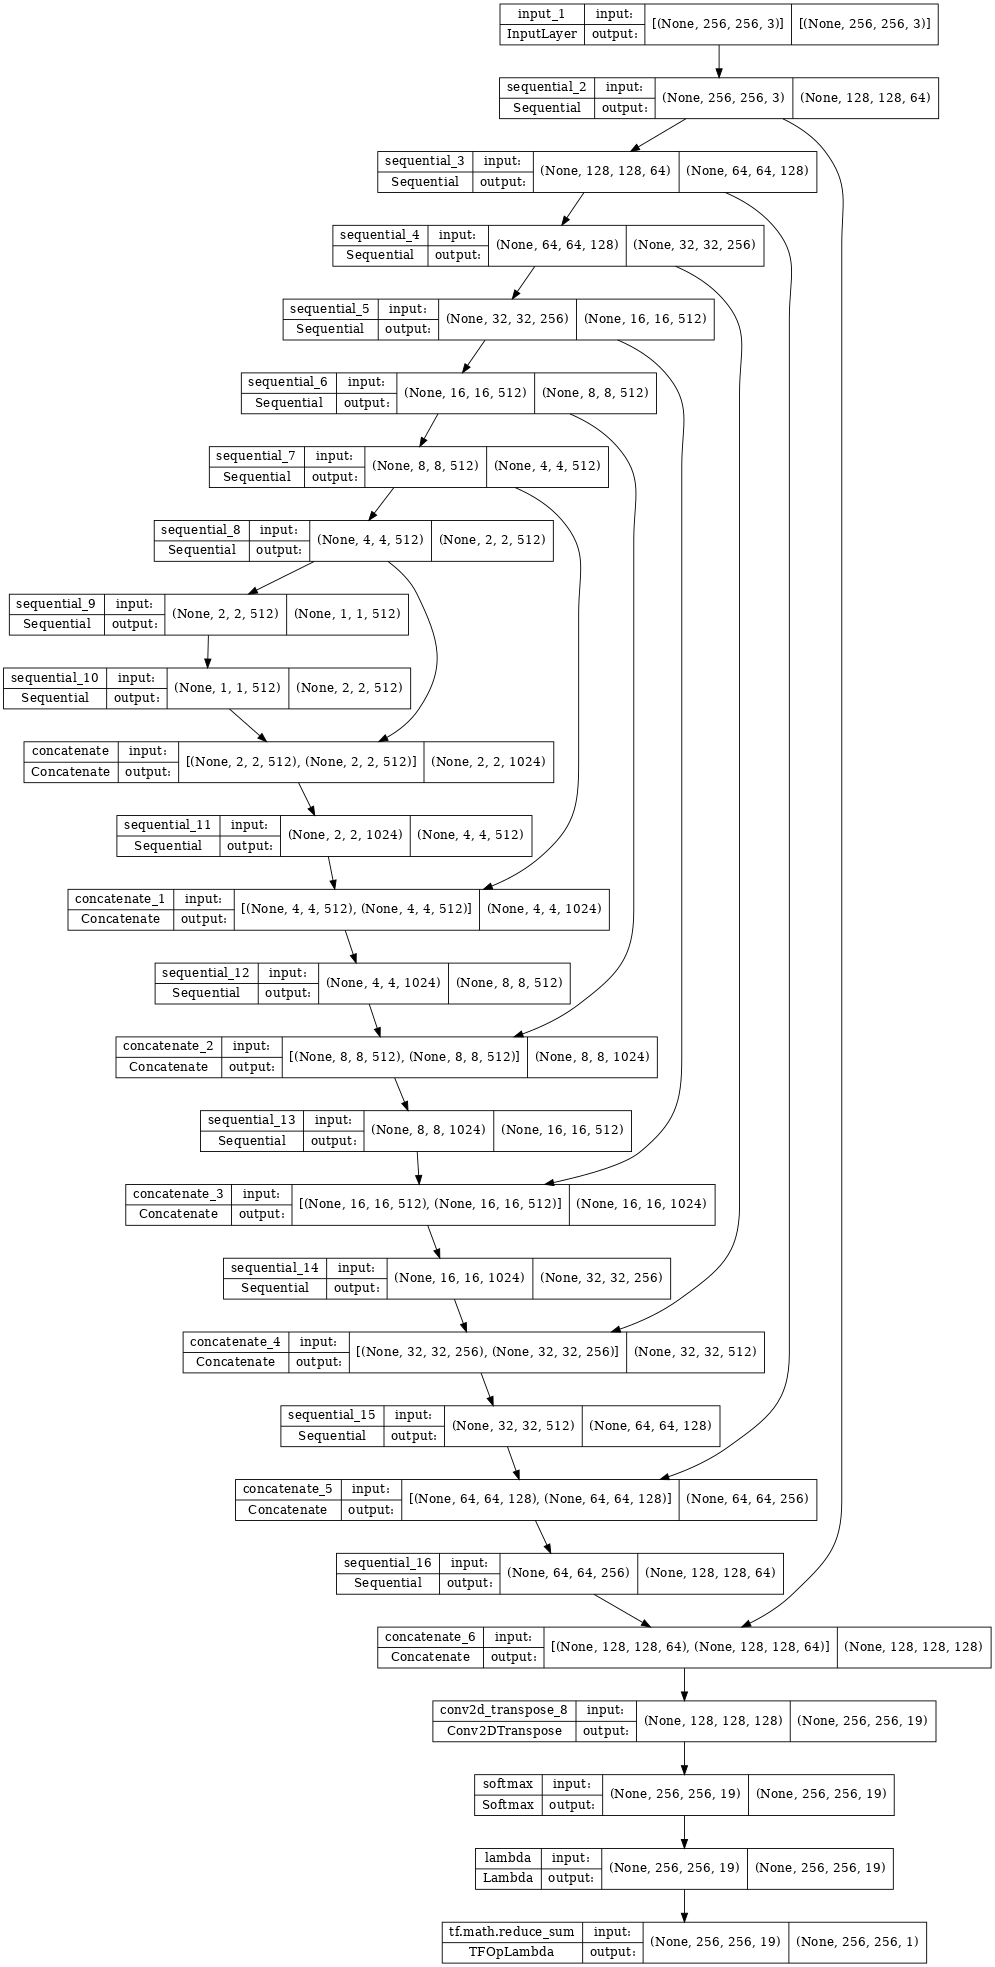

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Probamos el generador pasando un dato a través de la red. Por el momento no esperemos resultados notables pues los pesos tienen valores aleatorios: solo que la entrada puede ser procesada; es decir, que hayamos construido el modelo correctamente.

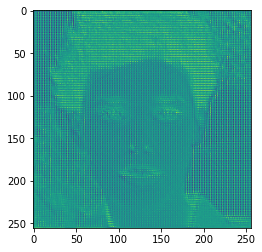

In [25]:
gen_output = generator(xim[tf.newaxis, ...]) #, training=False)
gen_output[0].shape
plt.imshow(gen_output[0][0]*50)

A modo de recordatorio, repetimos el diagrama del modelo que implementamos a continuación.

![Generator Update Image](pix2pix_unet_gan.jpeg)


En este diagrama $x'$ es un dato aproximado y $y$ es el dato real. Lo que pretendemos es incluir en $x$ características que lo hagan $x'$ semejante a $y$, no necesariamente igual. Que parezca que $x'$ es generado a partir de la misma distribución que $y$. 

Sea $P(Y)$ la distribución real de donde se muestreo $y$, y $x'$ un dato aproximado generado con $P(X)$ conocida, entonces:

$$
   P(Y) = P(Y|X) P(X)
$$
Luego, lo que queremos aproximar la probabilidad condicional por una función determinística:

$$
P(Y|X) \approx G(X; W)
$$
donde $G$ es el generador y $W$ sus parámetros (pesos de la red). Todo el componente aleatorio será responsabilidad de $P(X)$.

Para encontrar este generador usarémos un enfoque del tipo Redes Generadoras Antagónica (GAN). con un discriminador en vez de un detector.


## Discriminador

El discriminador es una red convolucional que tiene como salida un tensor 2D (en este caso de 1 canal). Cada  salida en el discriminador se calcula usando un parche de la imagen de entrada como soporte. Cada salida es responsable de indicar si su soporte corresponde a un par con la image real o no. Ver [pix2pix paper](https://arxiv.org/abs/1611.07004).

* El discriminador procesa un par de entrada y produce un tensor de salida. 

* Aunque para cada imágen $x$ procesada pro $G$ lo llamaremos dos veces: una para evaluar el par con datos generados y para evaluar par con dato reale. En realidad procesa por lotes, no por pares, pero ese detalle no es necesario para entender el funcionamiento de pix2pix.

* Reusamos los bloques `downsample`: `Conv2D` (con submuestreo) -> `BatchNormalization` -> `LeakyReLU` obteniendo una salida de `(batch_size, 30, 30, 1)`.

* Por conveniencia, a salida del Discriminador se pone una activación sigmoidal, sino que se deja lineal para interpretar como logits, valores reales en el intervalo $(-\infty, \infty)$.


In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=INPUT_DIMS,  name='input_image')
    tar = tf.keras.layers.Input(shape=OUTPUT_DIMS, name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels+1)

    down1 = downsample(64,  4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)     # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)     # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)      # (batch_size, 32, 32, 128)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 30, 30, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 17, 17, 512)
    last = tf.keras.layers.Conv2D(filters    =1, 
                                  kernel_size=4, 
                                  strides    =1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 14,14, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

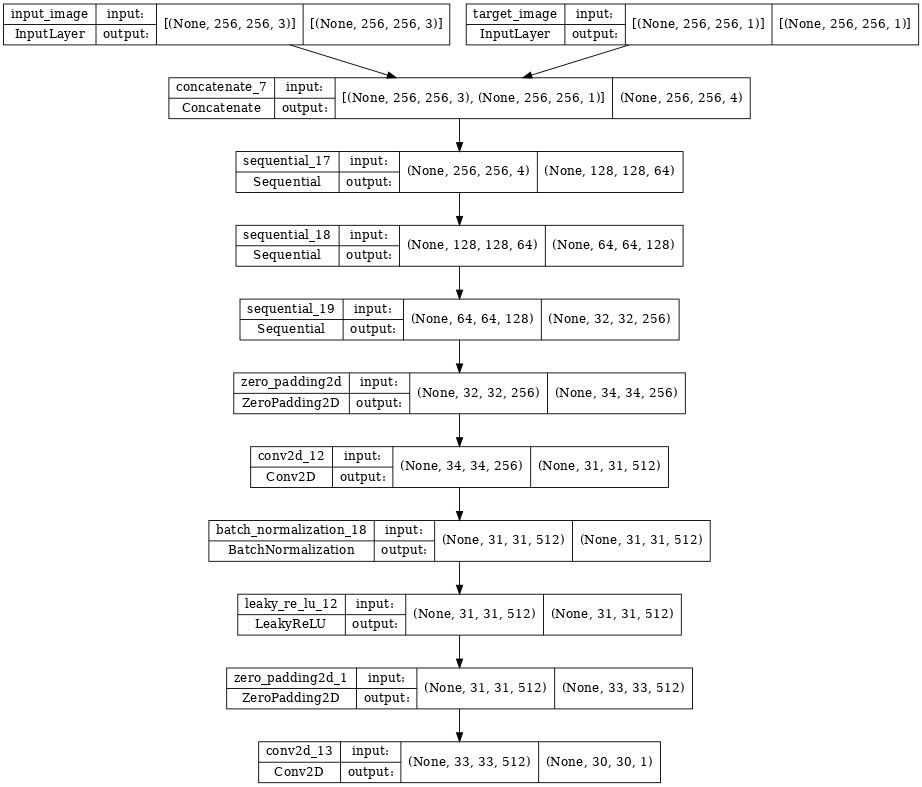

In [27]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Probamos el Discriminador pasando la salida "dummy" del generador. olo es para pobar que este corectamente implementado, los pesoa aun son aleatorios.

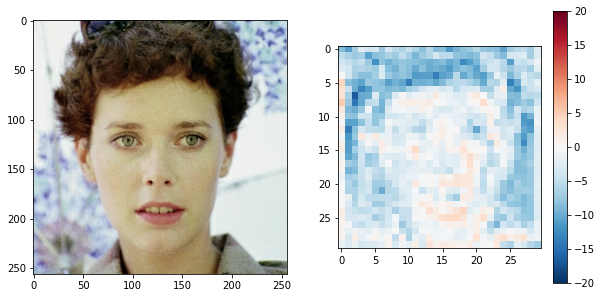

In [28]:
disc_out = discriminator([xim[tf.newaxis, ...], gen_output[0]], training=False)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow((xim+1)/2)
plt.subplot(122)
plt.imshow(disc_out[0, ..., -1]*200, vmin=-20, vmax=20, cmap='RdBu_r')  #*100
plt.colorbar()

## Funciones de Pérdida (*Losses*) de la GAN

En el ejemplo de tensorflow se emplea una pérdida que:

1. Compara la imagen generada con la real mediante (evalua el mapeo pix2pix) usando MSE (L1). En nuestro problema esto no tenen sentido dado que no pretendemos generar la imagen exacta original, sino solo imponer textura en la imagen aproximada $x$ (generada por el VAE).

2 Calcula la entropía-cruzada binaria entre cada elemento de la salida del discriminador y un 1. 

Para entrenar el generador queremos que cada región de la imagen generada sea realista. Es decir, la pérdida del generador mide la discordancia entre la salida del discriminador y el vector de 1's


Para entrenar el discriminador medimos de su salida:

* La concordancia (signo negativo) con un el vector de 1's. Diriamos que el generador le pasó un *strike* al discriminador.

* La discordancia con un el vector de 1's, debe detectar como reales los reales.

**Resumiedo nuestra estrategia:** 

* Contamos con pares de datos $(x,y)$ 

* Para cada dato $x$ realizamos una predicción (imagen con textura)  $\hat y$ mediante el generador, $G$. 

* Luego el discriminador $D$ obtienen un tensor que califica la veracidad de un parche (de soporte) en  $y$ real y la predicción $\hat y$; digamos que la salida  para el $i$-ésimo dato la denotamos $\hat z_i \in [0,1] $.

* Lo que esperamos es que el discriminador aproxime con $\hat z$ a $z = \mathbf{1}$ si dato es real, y a $\hat z = \mathbf{0}$ si el dato es sintético. 

* El costo del discriminador lo calcularemos mediate la entropía cruzada (cross entropy):

$$
    L (\hat z ) = - \frac{1}{N}\sum_{i:z_i=1} z_i \log \hat z_i - \frac{1}{N}\sum_{i:z_i=0} (1-z_i) \log (1-\hat z_i)
$$
donde $N$ es el número de pares imágenes de entrenamiento.

* Demos un paso mas para simplificar la red. Asumimos que el discriminador calcula los *logits* $\alpha$ en vez de las probabilidades: 
$$
\alpha_i = \log \hat z_i \in (-\infty, \infty).
$$
Luego la **pérdidad del discriminador** estará dada por: 
$$
    L (\hat z ) = - \frac{1}{N} \sum_{i: z_i\in \{0, 1\}} \alpha_i.
$$

* Consecuentemente, la **pérdidad del generdor** queda
$$
    L (\hat z ) =  - \frac{1}{N} \sum_{i:z_i=0} \alpha_i.
$$


Por ello usamos

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Loss del Discriminador

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss        = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss   = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss  = real_loss + generated_loss
    return total_disc_loss

### Loss del Generador

En el caso de la ṕérdida del generador, con el fin de guiar la predicción incluimos el error de reconstrucción
$$
    L (\hat z ) =  - \frac{1}{N} \sum_{i:z_i=0} \alpha_i + \Lambda \, MAE(y, x^\prime)
$$
donde MAE es la Media de los Errores Absolutos y $\Lambda$ es un parámetro positivo que pesa la contribución de cada término. 

In [31]:
LAMBDA = 100

In [32]:
def generator_loss(disc_generated_output, gen_map, gen_prob, target):
    '''
    el generador debe entrenarse para maximizar los errores de detección de imágenes sintéticas
    '''  
    # Entropia cruzada a partir de logits del discriminador
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # MAE reconstrucción en generador
    l1_loss = tf.reduce_mean(tf.abs(target - gen_map))
    # Entropia cruzada a partir de logits del generador
    # ce_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(target, gen_prob))   
    # Gini (entropy) penalty
    ce_loss = -tf.reduce_mean(tf.square(gen_prob))
    
    # Suma de los componentes del error
    total_loss = gan_loss + LAMBDA * l1_loss + 100*ce_loss
    
    return total_loss, gan_loss, l1_loss, ce_loss

### Optimizadores

Usamos el algoritmo *Adam* tanto para el generador como al discriminador. Dichas optimizaciones se realizan en paralelo (evolucionan en forma distinta) por lo que requerimos dos instancias de Adam.

In [33]:
generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Puntos de  control (*Checkpoints*)

Durante el entrenamiento monitoramos el proceso e iremos guardaremos (salvamos en arhivo) los valores de los pesos de el discriminador y el generador.

In [34]:
checkpoint_dir = './../training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Definimos una función para ir desplegando los avances del algoritmo.

In [35]:
def generate_images(model, x_input, y_input):
    
    # con training=True se obtienen las metricas sobre el Lote. 
    # En otro caso, no se evaluan y se regresan las del entrenamiento.
    y_pred, probs = model(x_input, training=True)  
     
    plt.figure(figsize=(20, 15))
    display_list = [ y_input[0], x_input[0], y_pred[0], probs[0]]
    title        = ['Objetivo, $y$', 'Fuente $x$', 'P2P  $x^\prime$', 'Segmentación']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        if i<3: 
            plt.imshow((display_list[i]+1)/2) 
        else: 
            plt.imshow(np.argmax(display_list[i], axis=-1)) 
        plt.axis('off') 
    plt.show()
    

Probamos la función

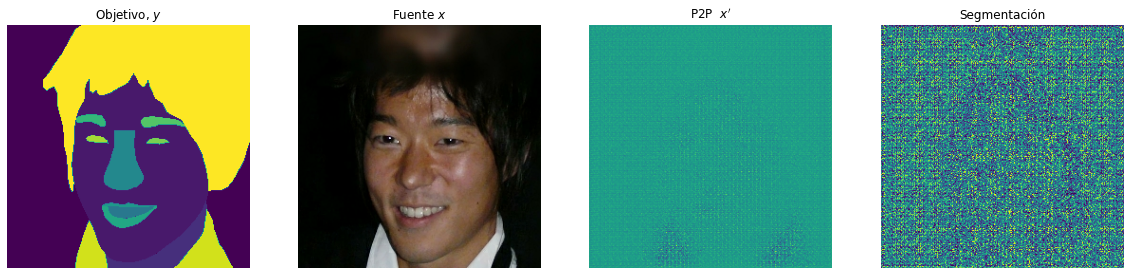

(1, 256, 256, 3) (1, 256, 256, 1)


In [36]:
for x_input, y_input in train_xy.take(1):
    generate_images(generator, x_input, y_input)
    print(x_input.shape, y_input.shape)
    break

Funciona! Dado que no hemos entrenado el modelo, es resultados ($x^\prime$) no tienen significado aún.

## Entrenamiento

Basados el el proceso arriba ilustrado, usaremos para el entrenamiento una estrategia del tipo Generador por Redes Adversarias (GAN).

In [37]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

A continuación se muestra la función que se llama a cada paso de entrenamiento. Esta función recibe pares de imágenes $(x,y)$ de entrada.

In [38]:
@tf.function
def train_step(input_image, target, step):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
        gen_map, gen_prob     = generator(input_image, training=True)
        disc_real_output      = discriminator([input_image, target],  training=True)
        disc_generated_output = discriminator([input_image, gen_map], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ce_loss = generator_loss     (disc_generated_output, gen_map, gen_prob, target)
        disc_loss  = discriminator_loss (disc_real_output, disc_generated_output)

    generator_gradients     = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,     discriminator.trainable_variables)

    generator_optimizer.apply_gradients    (zip(generator_gradients,     generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss',   gen_gan_loss,   step=step//1000)
        tf.summary.scalar('gen_l1_loss',    gen_l1_loss,    step=step//1000)
        tf.summary.scalar('gen_ce_loss',    gen_ce_loss,    step=step//1000)
        tf.summary.scalar('disc_loss',      disc_loss,      step=step//1000)
        
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        

Ahora defnimos el lazo (*loop*) completo de entrenamiento que invoca al paso de entrenamiento. Esta función es tal cual se propone en el ejemplo de $tf$:

- Iterar un número de pasos (steps)
- Cada 10 iteraciones imprime un punto '.'
- Cada 1K iteraciones muestra el progreso al desplegar la imagen generada.
- Cada 5K iteraciones guarda los pesos (checkpoint. 

In [39]:
def fit(train_xy, test_xy, steps):
    
    # toma un lote, batch de pares (x,y)
    x, y = next(iter(test_xy.take(1)))
    start = time.time()
    
    for step, (x, y) in train_xy.repeat().take(steps).enumerate():
        
        # muestra avance
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0: 
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            
            start = time.time()
            generate_images(generator, x, y)
            print(f"Step: {step//1000}k")

        # paso de entrenamiento
        train_step(x,y, step)
        if (step+1) % 10 == 0: print('.', end='', flush=True)

        # Checkpoint every 5k steps
        if (step + 1) % 5000 == 0:
              checkpoint.save(file_prefix=checkpoint_prefix)


Usando TensorBoard para monitorear el entrenamiento

Tensorflow se debe lanzar antes de iniciar el entrenamiento. Ejecutar el siguiente códico en una celda de código.

In [40]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

## Entrenamiento

Desplegamos resultados conforme avance el entrenamiento. 

Time taken for 1000 steps: 25.65 sec



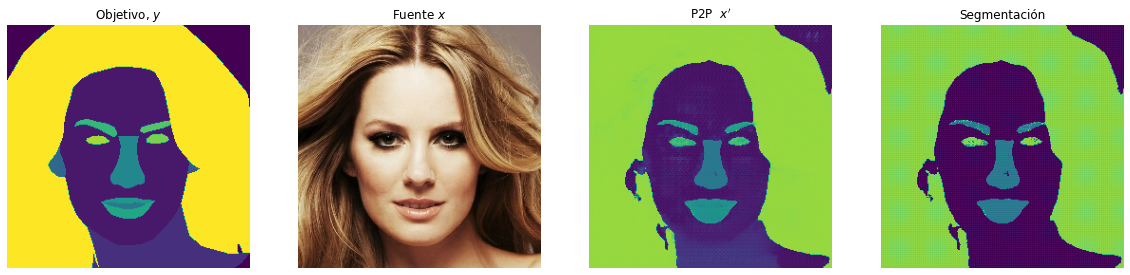

Step: 79k
....................................................................................................

In [48]:
fit(train_xy, test_xy, steps=80000)

Durante el entrenamiento es importante verificar algunas métricas para constatar que se esté evolucionando como esperamos: que no tengamos una convergencia temprana, ni dominio del discriminador o del generador. Es es que la párdida de alguno de ellos no se haga muy pequeña.

Lo deseable es que la perplejidad (confusión) del discriminador sea del 50%. esto es que en promedio, las probabilidades de de la verasidad en el discriminador sea: $\mathbb{E} \left\{ -log \, \hat z_i \right\} = \log(2) = 0.693$. Esta es una buena medida para los términos de costo del generador y discriminador.

Verfiquemos durante el entrenamiento lo siguiente.

* Si `disc_loss<0.69` entonces el discriminador tiene un mejor desempeño que un clasificador aleatorio en pares reales y sintéticos.

* Si `gen_gan_loss<0.69` entonces el generador logra confundir al dicriminador las mas de las veces.

* El térmono MAE debe ir reduciendose.


## Restore the latest checkpoint and test the network

In [45]:
!ls {checkpoint_dir}

checkpoint		     ckpt-20.index
ckpt-10.data-00000-of-00001  ckpt-21.data-00000-of-00001
ckpt-10.index		     ckpt-21.index
ckpt-11.data-00000-of-00001  ckpt-22.data-00000-of-00001
ckpt-11.index		     ckpt-22.index
ckpt-12.data-00000-of-00001  ckpt-23.data-00000-of-00001
ckpt-12.index		     ckpt-23.index
ckpt-13.data-00000-of-00001  ckpt-2.data-00000-of-00001
ckpt-13.index		     ckpt-2.index
ckpt-14.data-00000-of-00001  ckpt-3.data-00000-of-00001
ckpt-14.index		     ckpt-3.index
ckpt-15.data-00000-of-00001  ckpt-4.data-00000-of-00001
ckpt-15.index		     ckpt-4.index
ckpt-16.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-16.index		     ckpt-5.index
ckpt-17.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-17.index		     ckpt-6.index
ckpt-18.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-18.index		     ckpt-7.index
ckpt-19.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-19.index		     ckpt-8.index
ckpt-1.data-00000-of-00001   ckpt-9.data-00000-of-00001
ckpt-1.index		   

Una vez que se entrena el modelo, leemos el Nombre del archivo del último *checkpoint* y cargamos los pesos.

In [46]:
# Restoring the latest checkpoint in checkpoint_dir
chkpnt = tf.train.latest_checkpoint(checkpoint_dir)         
chkpnt = './../training_checkpoints/ckpt-16' 
checkpoint.restore(chkpnt)


## Probar el generador con datos de prueba

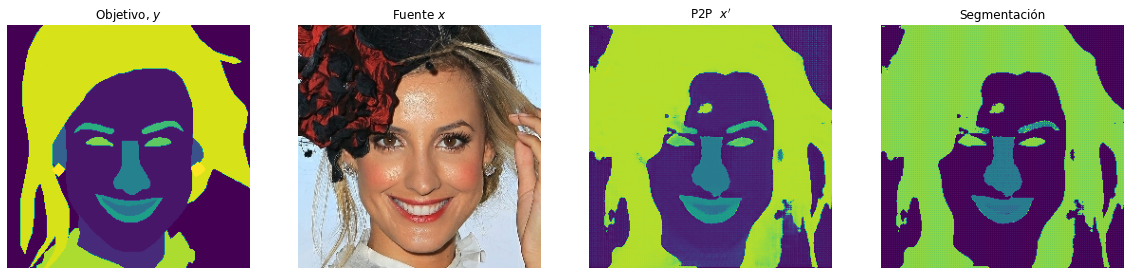

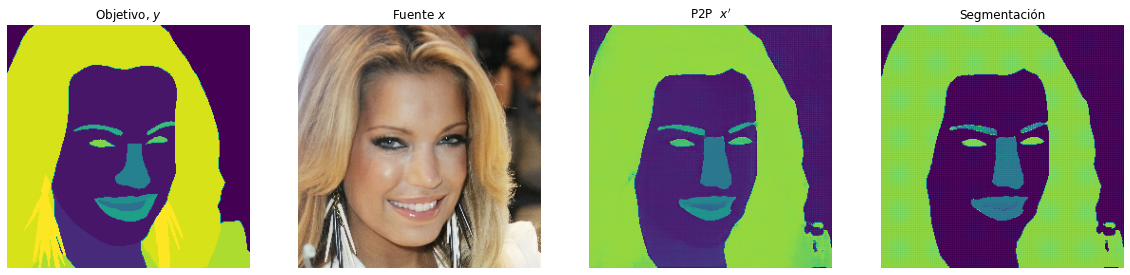

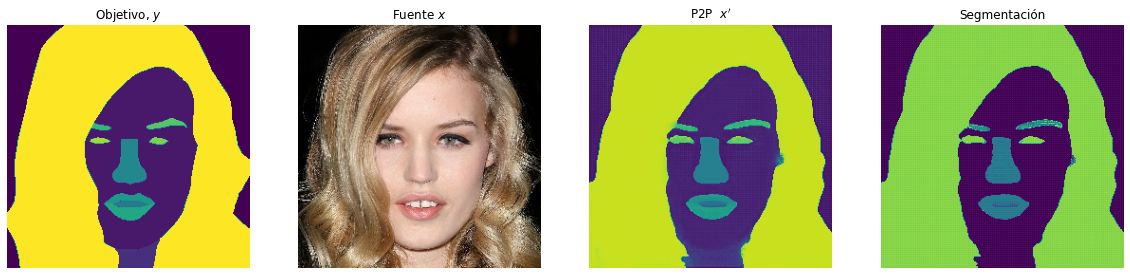

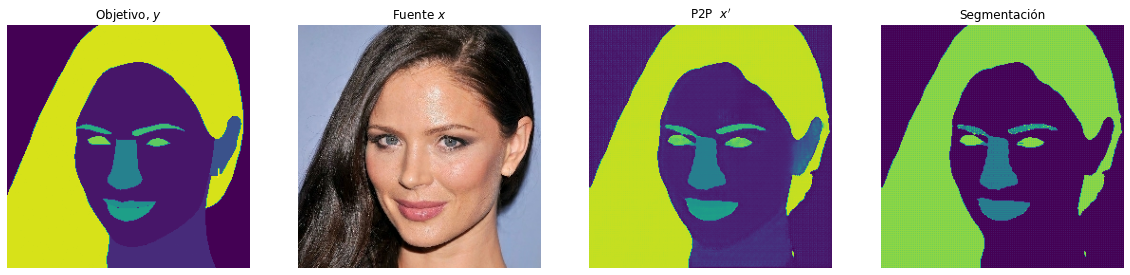

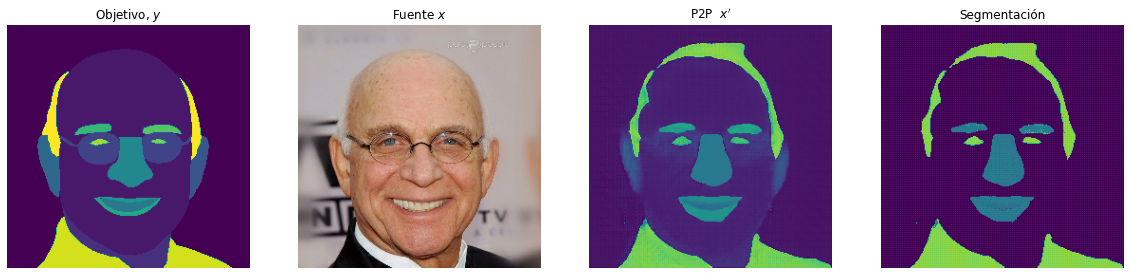

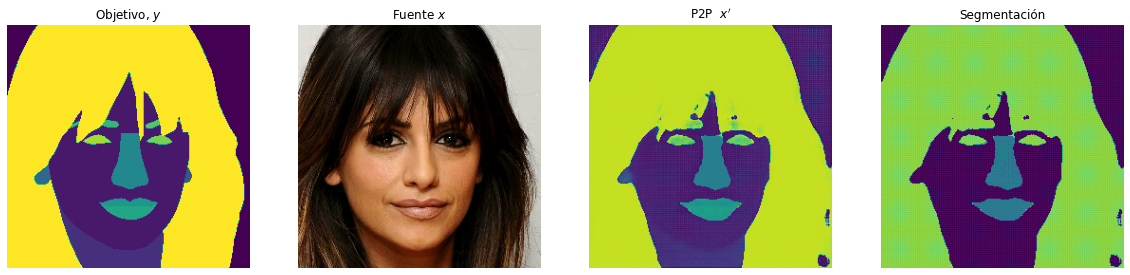

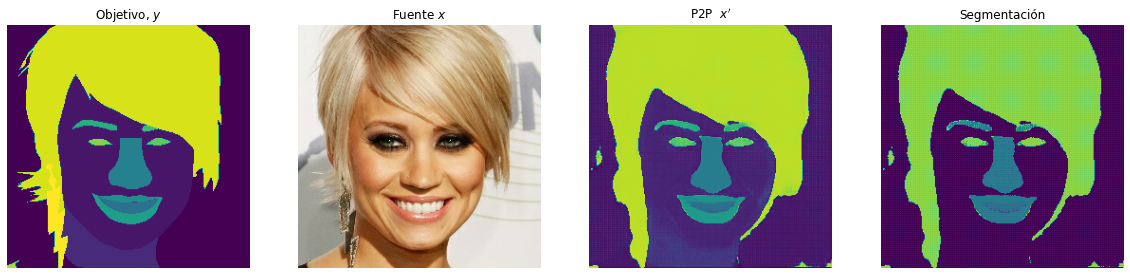

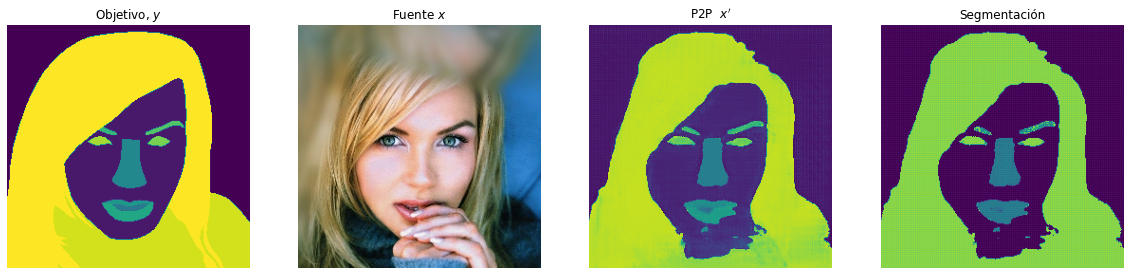

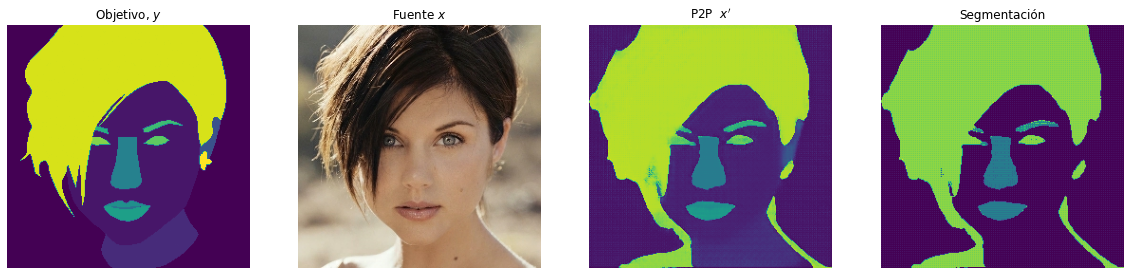

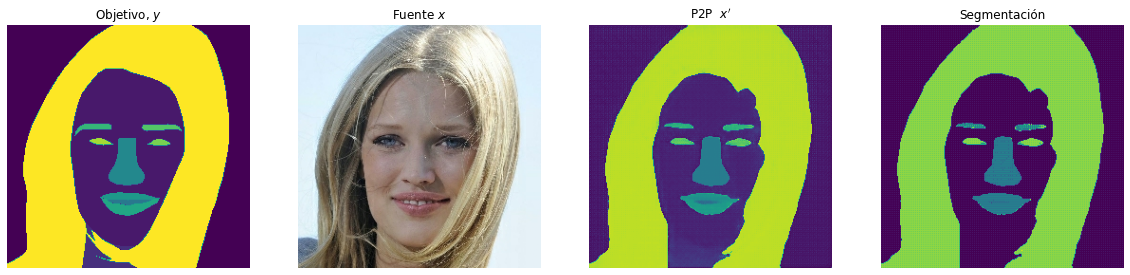

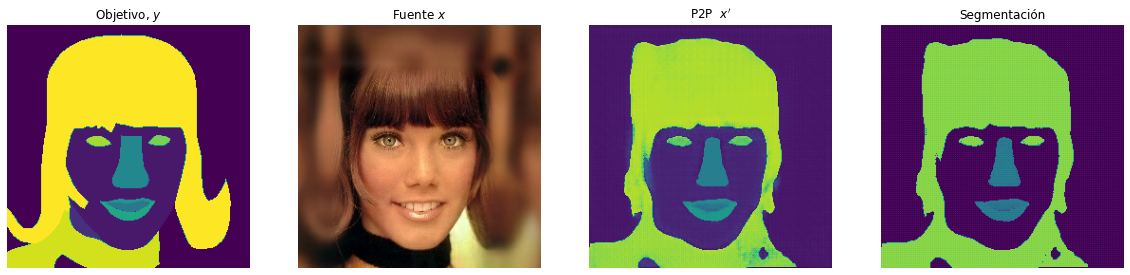

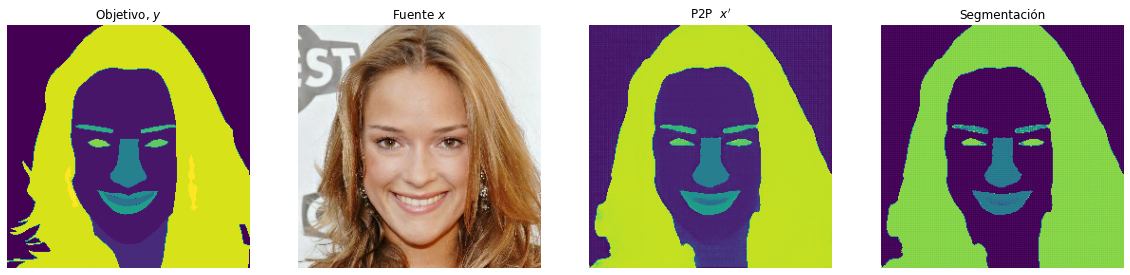

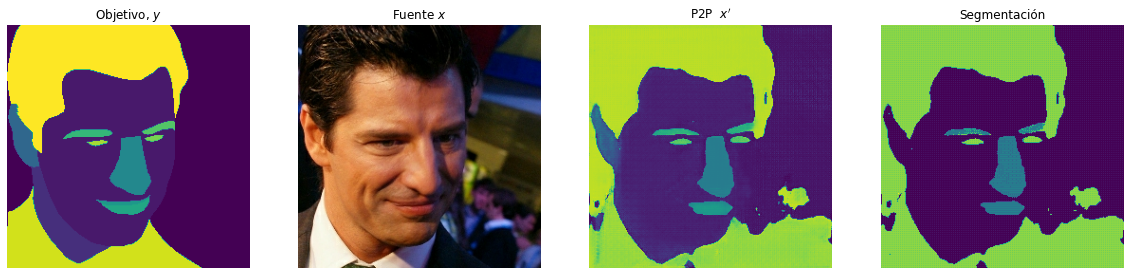

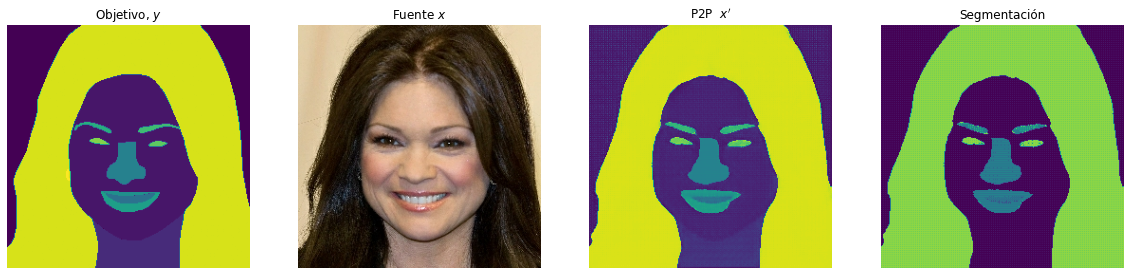

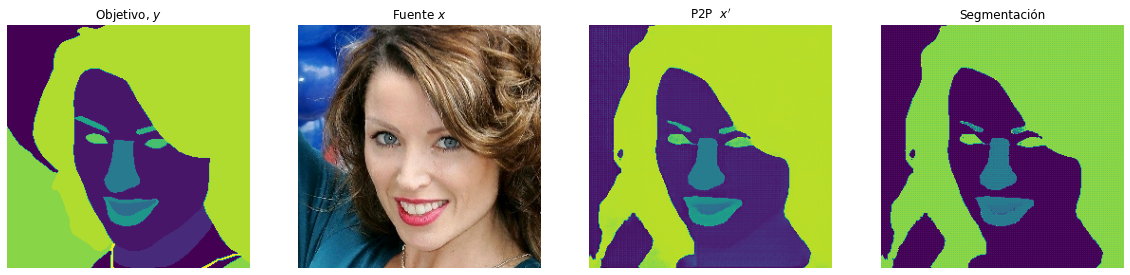

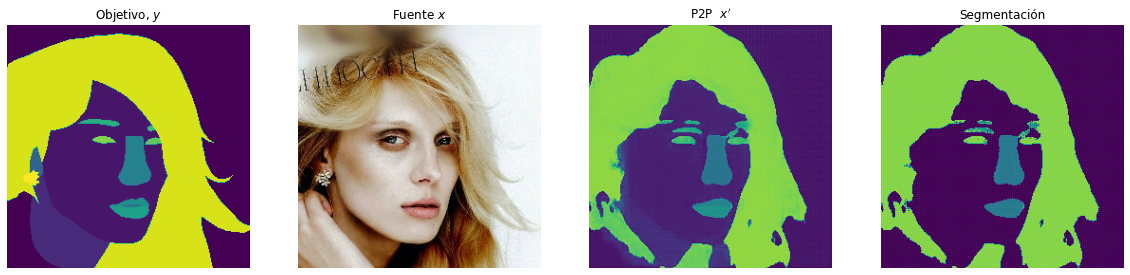

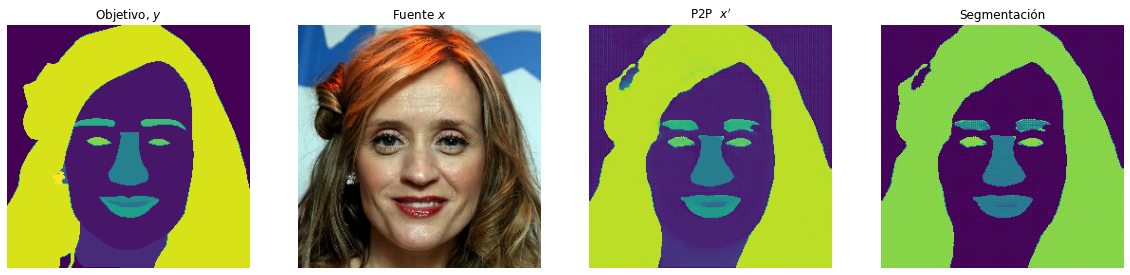

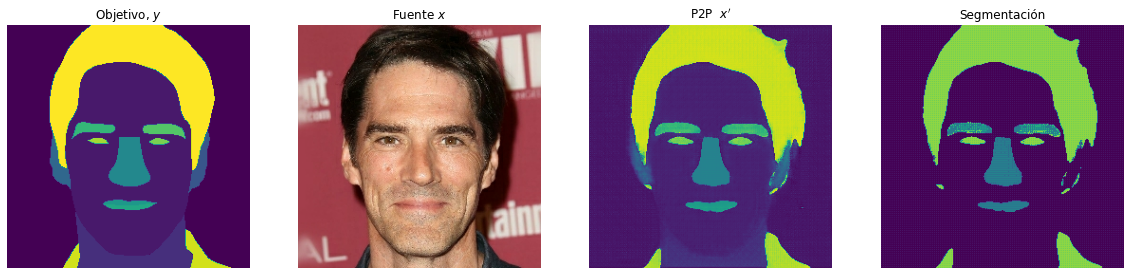

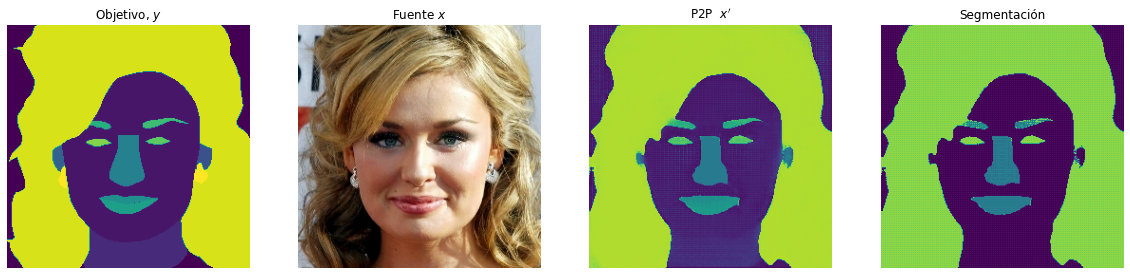

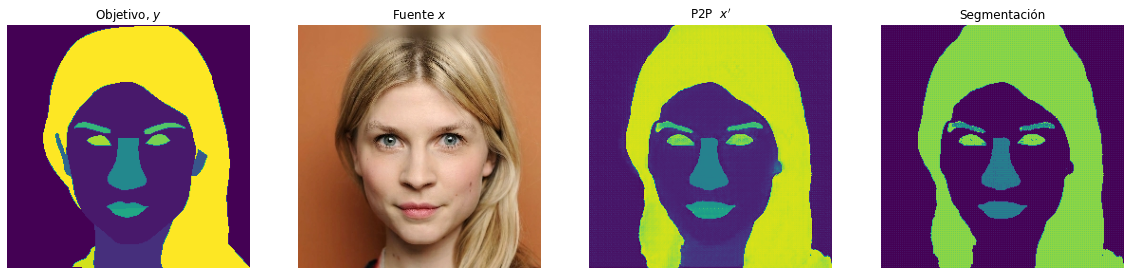

In [47]:
for inp, tar in test_xy.take(20):
    generate_images(generator, inp, tar)

Notamos que el modelo Px2Pix pueded efectivamente añadir textura a las imágenes base generadas con el [VAE](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/vae_conv/vae_conv.html). Existen algunas imágenes texturizadas con una apariencia muy realista, aunque en otras se introducen distorciones. 

Mientras tanto, salvamos los pesos del modelo para poder usarlo posteriormente.

In [50]:
generator.save_weights('gen_weights.h5')
discriminator.save_weights('dis_weights.h5')
